In [5]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect

def initializer(func):
    """
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    names, varargs, keywords, defaults = inspect.getargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper
#%%

#fixed parameters
QE = 0.55
resolution_element=57#microns
pixel_size = 13#microns
Gain_ADU = 0.53 #e-/e-
Throughput = 0.13
Atmosphere = 0.5
#
# CIC_charge = 0.005 # e/pix/frame
# Dard_current = 0.08 # e/pix/hour
# Sky_LU = 10000 # 200 000 in 2018


class Observation:
    @initializer
    def __init__(self, exposure_time=50, counting_mode=False, Signal=1.25E-17, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, flight_background_damping = 0.9, Additional_background_2018 = 0.0007,acquisition_time = 2,coeff_stack=2):
        self.ENF = 2 if counting_mode else 1
        if counting_mode:
            self.Photon_count_loss = 0.7 if readout_time==1.5 else 0.8 #a contraindre...
        else:
            self.Photon_count_loss =  1
        self.cosmic_ray_loss = np.minimum(0.005*exposure_time,1)
        self.QE_efficiency = self.Photon_count_loss * QE#* (1-cosmic_ray_loss)#ne devrait pas etre la 
        self.RN_fraction_kept = 0.05 if counting_mode else 1
        self.RN_final = RN  * self.RN_fraction_kept / EM_gain #Are we sure about that?
        self.CIC_noise = np.sqrt(CIC_charge) if counting_mode else np.sqrt(CIC_charge*2)
        self.Dark_current_f = Dard_current * exposure_time / 3600 # e/pix/frame
        self.Dark_current_noise =  np.sqrt(self.Dark_current_f) if counting_mode else np.sqrt(self.Dark_current_f*2)
        self.Additional_background = Additional_background_2018 * exposure_time *(1-flight_background_damping) # e/pix/f
        self.Additional_background_noise = np.sqrt(self.Additional_background) if counting_mode else np.sqrt(self.Additional_background*2)
        self.lu2ergs = 2.33E-19/1000
        self.Sky_ = Sky_LU*self.lu2ergs#/1000*2.33E-19 # ergs/cm2/s/arcsec^2
        self.factor_el = self.QE_efficiency * Throughput * Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
        self.sky = Sky_LU*self.factor_el*exposure_time  # el/pix/frame

        self.Sky_f =  self.sky * EM_gain * Gain_ADU  # el/pix/frame
        self.Sky_noise = np.sqrt(self.sky) if counting_mode else np.sqrt(self.sky*2)
        self.N_images = acquisition_time*3600/(exposure_time+readout_time)
        self.N_images_true = self.N_images * coeff_stack * (1-self.cosmic_ray_loss)
        self.Total_sky = self.N_images_true * self.sky
        self.sky_resolution = self.Total_sky * (resolution_element/pixel_size)**2# el/N exposure/resol
        self.Signal_LU = Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
        self.Signal_el = self.Signal_LU*self.factor_el*exposure_time  # el/pix/frame#     Signal * (sky / Sky_)  #el/pix
        # print(Signal )
        # print(self.Signal_LU )
        # print(self.Signal_el )
#         if counting_mode:
#             print('%0.1f < ExpTime < %0.1f' %(0.01/factor_el/Signal_LU,0.1/factor_el/Signal_LU))
    
        self.Signal_resolution = self.Signal_el *self.N_images_true* (resolution_element/pixel_size)**2# el/N exposure/resol
        self.eresolnframe2lu = self.Signal_LU/self.Signal_resolution
        self.signal_noise = np.sqrt(self.Signal_el) if counting_mode else np.sqrt(self.Signal_el*2)     #el / resol/ N frame
        self.signal_noise_resol = self.signal_noise *resolution_element/pixel_size   # el/resol/frame
        self.signal_noise_nframe = self.signal_noise *np.sqrt(self.N_images_true)  # el/resol/frame
        self.Total_noise_final = np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        self.factor = np.sqrt(self.N_images_true) * (resolution_element/pixel_size)
        self.Total_noise_nframe = self.Total_noise_final * np.sqrt(self.N_images_true)
        self.Total_noise_resol = self.Total_noise_nframe * (resolution_element/pixel_size)
        self.SNR = self.Signal_resolution/self.Total_noise_resol
  

/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_49855/311187737.py:18: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  names, varargs, keywords, defaults = inspect.getargspec(func)


In [61]:
#Nominal = Observation(exposure_time=50,Sky_LU=np.linspace(1e4,1e6,100), counting_mode=False,Signal=4.55e-16,acquisition_time=0.2)#.PlotNoise(x='Sky_LU')
Nominal = Observation(exposure_time=np.linspace(1,150),Sky_LU=1e4, counting_mode=False,Signal=4.55e-16,acquisition_time=0.2)#.PlotNoise(x='Sky_LU')

print(Nominal.exposure_time)
print(Nominal.SNR)

[  1.           4.04081633   7.08163265  10.12244898  13.16326531
  16.20408163  19.24489796  22.28571429  25.32653061  28.36734694
  31.40816327  34.44897959  37.48979592  40.53061224  43.57142857
  46.6122449   49.65306122  52.69387755  55.73469388  58.7755102
  61.81632653  64.85714286  67.89795918  70.93877551  73.97959184
  77.02040816  80.06122449  83.10204082  86.14285714  89.18367347
  92.2244898   95.26530612  98.30612245 101.34693878 104.3877551
 107.42857143 110.46938776 113.51020408 116.55102041 119.59183673
 122.63265306 125.67346939 128.71428571 131.75510204 134.79591837
 137.83673469 140.87755102 143.91836735 146.95918367 150.        ]
[ 7.50301012 11.63933148 12.5910915  12.96425564 13.1289844  13.19472745
 13.20543266 13.18216978 13.13629818 13.07447728 13.00086422 12.91818342
 12.8282904  12.73248848 12.63171614 12.52666264 12.41784208 12.30564229
 12.19035794 12.0722136  11.95137994 11.82798548 11.70212514 11.57386652
 11.44325464 11.31031546 11.17505849 11.03747883 

interactive(children=(FloatSlider(value=505000.0, description='sky', max=1000000.0, min=10000.0, step=100.0), …

ExposureTimeCalulator()

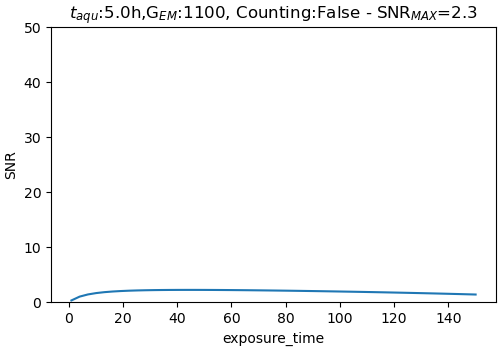

In [110]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )
 
class ExposureTimeCalulator(widgets.HBox):
     
    def __init__(self):
        super().__init__()
        output = widgets.Output()
        self.x = Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)
 
        with output:
            self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(5, 3.5))
        self.line, = self.ax.plot(self.x, self.x)#Nominal.SNR)
        self.fig.canvas.toolbar_position = 'bottom'
        self.ax.set_ylim((0,50))
        self.ax.set_ylabel('SNR')


        # controls.layout = make_box_layout()
         
        out_box = widgets.Box([output])
        output.layout = make_box_layout()
 
        # observe stuff
#         int_slider.observe(self.update, 'value')
#         text_xlabel.observe(self.update_xlabel, 'value')
#         text_ylabel.observe(self.update_ylabel, 'value')
         
#         text_xlabel.value = 'x'
#         text_ylabel.value = 'y'
        # acquisition_time = widgets.IntSlider( min=0.1, max=10, step=0.1)#, style = {'description_width': 'initial'})
        widgets.interact(self.update,sky=(1e4, 1e6, 100),x_axis=['exposure_time','test'],acquisition_time=(0.1, 10, 0.1),counting_mode=False,Signal=(-18,-16,0.01),EM_gain=(200,2000,1),RN=(30,120,1), CIC_charge=(0.005,0.05,0.001), Dard_current=(0.08,0.2), readout_time=(1.5,15))
    # def __init__(self, exposure_time=50, counting_mode=False, Signal=1.25E-17, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, flight_background_damping = 0.9, Additional_background_2018 = 0.0007,acquisition_time = 2,coeff_stack=2):


        # add to children
        # self.children = [controls, output]
     
    def update(self, sky,x_axis,acquisition_time,counting_mode,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time):
        """Draw line in plot"""
        # print(sky)
        new = Observation(exposure_time=np.linspace(1,150),Sky_LU=sky, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=10**Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time)
        self.line.set_ydata(new.SNR)
        self.ax.set_xlabel(x_axis)
        self.ax.set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)))

        # self.fig.canvas.draw()
 
         
ExposureTimeCalulator()